In [1]:
import numpy as np
import scipy.io as sio
import scipy.sparse as sp
import matplotlib.pylab as plt
import seaborn as sns

from scipy.linalg import expm
from numpy.linalg import matrix_power
import os

import ssgetpy
import latextable
import mat73
import pickle

In [2]:
# !pip install latextable

In [3]:
# !pip install mat73

In [2]:
plt.rcParams['text.usetex'] = True

# Functions

In [3]:
def get_matrices(data_links_fpath, data_dir='data', download=True):
    
    matrix_format    = 'MAT'
    matrix_label_dict = {}
    matrix_fpath_dict = {}
    matrix_list       = []
    
    with open(data_links_fpath, 'r') as f:
        data_links = f.readlines()
        data_links = [x.strip() for x in data_links]
        
    if not os.path.exists(data_dir) and download==True:
        os.mkdir(data_dir)

    for data_link in data_links:
        search_name = '/'.join(data_link.split('/')[-2:])
        try:
            matrices = ssgetpy.search(search_name);
            matrix  = matrices[0];
            matrix_list.append(matrix)
    
            matrix_group = matrix.group
            matrix_name  = matrix.name
            num_rows     = matrix.rows
            num_cols     = matrix.cols
            nnz          = matrix.nnz 

            matrix_extended_name = '{}/{}'.format(matrix_group, matrix_name)
    
            matrix_label_dict[matrix_name] = matrix_extended_name

            matrix_fpath                   = os.path.join(data_dir, '{}.mat'.format(matrix_name))
            matrix_fpath_dict[matrix_name] = matrix_fpath

            if not os.path.exists(matrix_fpath) and download==True:
                matrix.download(format=matrix_format, destpath=data_dir)
        except:
            pass
        
    return matrix_list, matrix_label_dict, matrix_fpath_dict

In [4]:
def randemacher_vector(size):
    return np.random.choice([-1.0, 1.0], size=size, replace=True, p=[0.5, 0.5])

In [5]:
def randemacher_vector_samples(size, num_samples, seed=0):
    np.random.seed(seed)
    return [randemacher_vector(size) for _ in range(num_samples)]

In [6]:
# Could be  made generic: passing two distributions could do the trick. e.g. from `scipy.stats`
# dist1 to choose T; dist2 to get indices of active rows 
def general_index_samples(size, num_samples, seed=0):
    pass

In [7]:
# corollary 1
def fixed_T_index_samples(size, num_samples, T, seed=0):
    np.random.seed(seed)
    num_active = T
    index_samples = []
    for _ in range(num_samples):
        sample = np.sort(np.random.choice(size, size=num_active, replace=False, p=None))
        index_samples.append(sample)
    return index_samples

# corollary 2
def uniform_T_index_samples(size, num_samples, seed=0):
    np.random.seed(seed)
    num_active = np.random.randint(0, size, 1)
    index_samples = []
    for _ in range(num_samples):
        sample = np.sort(np.random.choice(size, size=num_active, replace=False, p=None))
        index_samples.append(sample)
    return index_samples
        

# corollary 3
def fixed_p_index_samples(size, num_samples, p, seed=0):
    np.random.seed(seed)
    index_samples = []
    num_choices   = size
    for _ in range(num_samples):
        sample = np.where(np.random.random(num_choices) <= p)[0]
        index_samples.append(sample)
    return index_samples 

In [233]:
def compute_relative_error_lists(matrix_key,
                                func_key,
                                index_key,
                                p          = 0.6,
                                T          = 100,
                                m          = 100,
                                seed       = 0,
                                base_trace = None):
    
    matrix_label = matrix_label_dict[matrix_key]
    A            = A_dict[func_key][matrix_key]
    N            = A.shape[0] 
    if base_trace is not None:
        trace = base_trace
    else:
        trace = A.trace()

    x_list = randemacher_vector_samples(N, m, seed=seed)

    if index_key == 'fixed_T':
        index_samples = fixed_T_index_samples(N, m, T, seed=seed)
    elif index_key == 'uniform_T':
        index_samples = uniform_T_index_samples(N, m, seed=seed)
    elif index_key == 'fixed_p':
        index_samples = fixed_p_index_samples(N, m, p, seed=seed)

    sync_quadratic_list  = []
    async_quadratic_list = []

    mu_T = 0

    for i in range(m):
        k = i + 1
        x = x_list[i]
        idx = index_samples[i]
    
        sync_quadratic = x @ (A @ x)
        sync_quadratic_list.append(sync_quadratic)
    
        async_A =  A[idx]
        matvec = async_A @ x
        y = np.zeros(N)
        y[idx] = matvec
        async_quadratic = x @ y
        async_quadratic_list.append(async_quadratic)
        mu_T = mu_T + len(idx)

    mu_T = mu_T / m
    
    sync_trace_list  = []
    async_trace_list = []

    sync_sum  = 0.
    async_sum = 0.
    for i in range(m):
        k = i + 1
    
        sync_sum   += sync_quadratic_list[i]
        sync_trace = 1. / k * sync_sum
        sync_trace_list.append(sync_trace)
    
        async_sum   += async_quadratic_list[i]
        async_trace = N / mu_T * 1. / k * async_sum
        async_trace_list.append(async_trace)

    sync_relative_error_list  = []
    async_relative_error_list = []

    for i in range(m):
        sync_relative_error = abs(sync_trace_list[i] - trace) / abs(trace)
        sync_relative_error_list.append(sync_relative_error)
    
        async_relative_error = abs(async_trace_list[i] - trace) / abs(trace)
        async_relative_error_list.append(async_relative_error)
    
    relative_error_list_dict = {'sync'  : sync_relative_error_list,
                                'async' : async_relative_error_list}
    
    return relative_error_list_dict

In [9]:
def make_plot_single(relative_error_list_dict):
    
    sync_relative_error_list  = relative_error_list_dict['sync']
    async_relative_error_list = relative_error_list_dict['async']
    
    
    fig, ax = plt.subplots(1)
    ax.plot(async_relative_error_list, '--', color='blue', label='Asynchronous')
    ax.plot(sync_relative_error_list,  color='red',   label='Synchronous')

    ax.set_yscale('log')
    ax.grid(which='both')
    ax.legend()

    ax.set_ylim(top=1.)

    # plt.title('Randomized trace estimation',  fontsize=14);
    ax.set_title('{} ({})'.format(matrix_label_dict[matrix_key], 
                           func_label_dict[func_key]),  fontsize=14);
    ax.set_xlabel('Number of samples', fontsize=14);
    ax.set_ylabel('Relative error', fontsize=14);
    return fig, ax

In [16]:
def make_plot_multiple(relative_error_list_dict_list):

    sync_vectors  = []
    async_vectors = []

    for i, relative_error_list_dict in enumerate(relative_error_list_dict_list):
        
        sync_relative_error_list  = relative_error_list_dict['sync']
        async_relative_error_list = relative_error_list_dict['async']
    
        sync_vectors.append(sync_relative_error_list)
        async_vectors.append(async_relative_error_list)

    m = len(sync_vectors[0])
    sample_array = np.array(range(m))    
    
    sync_array  = np.array(sync_vectors)
    async_array = np.array(async_vectors)
    
    sync_mean_array  = np.mean(sync_array, axis=0)    
    async_mean_array = np.mean(async_array, axis=0)

    sync_std_array  = np.std(sync_array, axis=0)    
    async_std_array = np.std(async_array, axis=0)
 
    fig, ax = plt.subplots(1)
    ax.fill_between(sample_array,
                    sync_mean_array + sync_std_array,
                    sync_mean_array - sync_std_array,
                    alpha = 0.1,
                    color = 'red')

    ax.fill_between(sample_array,
                    async_mean_array + async_std_array,
                    async_mean_array - async_std_array,
                    alpha = 0.1,
                    color = 'blue')

    ax.plot(sync_mean_array, 
                '-', 
                color = 'red',
                label =  'Synchronous')

    ax.plot(async_mean_array, 
                '--', 
                color = 'blue',
                label =  'Asynchronous')

    ax.set_yscale('log')
    ax.grid(which='major')
    ax.grid(which='minor')
    ax.legend()

    # ax.set_ylim(top=0.1)

    ax.set_title('{} ({})'.format(matrix_label_dict[matrix_key], 
                           func_label_dict[func_key]),  fontsize=14);
    ax.set_xlabel('Number of samples', fontsize=14);
    ax.set_ylabel('Relative error', fontsize=14);
    return fig, ax


# Experiments

## Initialization

In [39]:
data_links_fpath                                  = 'matrices.txt'


# matrix_list, matrix_label_dict, matrix_fpath_dict
matrix_list, matrix_label_dict, matrix_fpath_dict = get_matrices(data_links_fpath)


# matrix_info
matrix_info = [] 
for matrix in matrix_list:
    matrix_group = matrix.group
    matrix_name  = matrix.name
    num_rows     = matrix.rows
    num_cols     = matrix.cols
    nnz          = matrix.nnz 
    
    matrix_extended_name = '{}/{}'.format(matrix_group, matrix_name)
    
    matrix_fpath = matrix_fpath_dict[matrix_name]
    try:
        data         = sio.loadmat(matrix_fpath)
        sparse_matrix           = data['Problem'][0][0][2]  
        if type(sparse_matrix) != type(sp.csc_matrix(1)):
            sparse_matrix           = data['Problem'][0][0][1]  
    except NotImplementedError:
        data         = mat73.loadmat(matrix_fpath)
        sparse_matrix           = data['Problem']['A']
    A            = sparse_matrix;
    N            = A.shape[0]
    trace        = A.trace()

    matrix_info.append([matrix_extended_name, num_rows, num_cols, nnz, trace])


# func_label_dict, A_dict
G_dict   = {}
GpI_dict = {}
for key, matrix_fpath in matrix_fpath_dict.items():
    try:
        data         = sio.loadmat(matrix_fpath)
        sparse_matrix           = data['Problem'][0][0][2]  
        if type(sparse_matrix) != type(sp.csc_matrix(1)):
            sparse_matrix           = data['Problem'][0][0][1]  
    except NotImplementedError:
        data          = mat73.loadmat(matrix_fpath)
        sparse_matrix = data['Problem']['A']
    
    G            = sparse_matrix
    N            = sparse_matrix.shape[0]
    
    A           = G
    G_dict[key] = G
    
    A             = G + sp.diags(np.ones(N))
    GpI_dict[key] = A

func_label_dict = {'G'    : '$A = G$',
                   'GpI'  : '$A = G + I$'}

A_dict = {'G'    : G_dict,
          'GpI'  : GpI_dict} 

In [44]:
matrix_info = sorted(matrix_info, key = lambda x: x[1])

In [45]:
matrix_info

[['Pajek/Roget', 1022, 1022, 5075, 1.0],
 ['HB/bcsstm08', 1074, 1074, 1074, 5502970.554556186],
 ['Arenas/email', 1133, 1133, 10902, 0.0],
 ['TKK/plbuckle', 1282, 1282, 30644, 320782248.2143822],
 ['Pajek/yeast', 2361, 2361, 13828, 536.0],
 ['SNAP/ca-GrQc', 5242, 5242, 28980, 12.0],
 ['SNAP/wiki-Vote', 8297, 8297, 103689, 0.0],
 ['SNAP/ca-HepTh', 9877, 9877, 51971, 25.0],
 ['SNAP/ca-CondMat', 23133, 23133, 186936, 58.0],
 ['Botonakis/thermomech_TC', 102158, 102158, 711558, 585.8708316701662],
 ['SNAP/web-Stanford', 281903, 281903, 2312497, 0.0],
 ['LAW/cnr-2000', 325557, 325557, 3216152, 87442.0]]

In [209]:
matrix_label_dict

{'ca-CondMat': 'SNAP/ca-CondMat',
 'bcsstm08': 'HB/bcsstm08',
 'ca-HepTh': 'SNAP/ca-HepTh',
 'ca-GrQc': 'SNAP/ca-GrQc',
 'Roget': 'Pajek/Roget',
 'wiki-Vote': 'SNAP/wiki-Vote',
 'plbuckle': 'TKK/plbuckle',
 'yeast': 'Pajek/yeast',
 'thermomech_TC': 'Botonakis/thermomech_TC',
 'web-Stanford': 'SNAP/web-Stanford',
 'cnr-2000': 'LAW/cnr-2000',
 'email': 'Arenas/email'}

In [42]:
matrix_fpath_dict

{'ca-CondMat': 'data/ca-CondMat.mat',
 'bcsstm08': 'data/bcsstm08.mat',
 'ca-HepTh': 'data/ca-HepTh.mat',
 'ca-GrQc': 'data/ca-GrQc.mat',
 'Roget': 'data/Roget.mat',
 'wiki-Vote': 'data/wiki-Vote.mat',
 'plbuckle': 'data/plbuckle.mat',
 'yeast': 'data/yeast.mat',
 'thermomech_TC': 'data/thermomech_TC.mat',
 'web-Stanford': 'data/web-Stanford.mat',
 'cnr-2000': 'data/cnr-2000.mat',
 'email': 'data/email.mat'}

## Runs

### trace > 0

In [15]:
%%time
fig_dir = 'figures'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

result_dir = 'results'
if not os.path.exists(result_dir):
    os.mkdir(result_dir)
    
matrix_key_list = ['Roget',
                   'bcsstm08', 
                   'plbuckle', 
                   'yeast',
                   'ca-GrQc',
                   'ca-HepTh', 
                   'ca-CondMat',
                   'thermomech_TC', 
                   'cnr-2000']

func_key_list   = ['G']
index_key_list  = ['fixed_T', 'uniform_T', 'fixed_p']
fixed_p         = 0.6
seed_list       = [i for i in range(10)]
num_samples     = 1000

for matrix_key in matrix_key_list:
    for func_key in func_key_list:
        for index_key in index_key_list:
            try:
                sparse_matrix = A_dict[func_key][matrix_key]
                N             = sparse_matrix.shape[0]      
                fixed_T     = int(np.ceil(fixed_p * N))

                relative_error_list_dict_list = []
                for seed in seed_list:
                    relative_error_list_dict = compute_relative_error_lists(matrix_key,
                                                                            func_key,
                                                                            index_key,
                                                                            p          = fixed_p,
                                                                            T          = fixed_T,
                                                                            m          = num_samples,
                                                                            seed       = seed)
                    relative_error_list_dict_list.append(relative_error_list_dict)
                
                result_fname = 'relative_error-{}-{}-{}.pickle'.format(matrix_key, func_key, index_key)
                result_fpath = os.path.join(result_dir, result_fname)
                with open(result_fpath, 'wb') as f: 
                    pickle.dump(relative_error_list_dict_list, f)
            except:
                print(matrix_key, fun_key, index_key)
            

CPU times: user 2h 4min 43s, sys: 30min 35s, total: 2h 35min 19s
Wall time: 27min 15s


In [78]:
matrix_key_list = ['Roget',
                   'bcsstm08', 
                   'plbuckle', 
                   'yeast',
                   'ca-GrQc',
                   'ca-HepTh', 
                   'ca-CondMat',
                   'thermomech_TC', 
                   'cnr-2000']

func_key_list   = ['G']
index_key_list  = ['fixed_T', 'uniform_T', 'fixed_p']

for matrix_key in matrix_key_list:
    for func_key in func_key_list:
        for index_key in index_key_list:
            
            result_fname = 'relative_error-{}-{}-{}.pickle'.format(matrix_key, func_key, index_key)
            result_fpath = os.path.join(result_dir, result_fname)
            with open(result_fpath, 'rb') as f: 
                relative_error_list_dict_list = pickle.load(f)
            
            #fig, ax    = make_plot_multiple(relative_error_list_dict_list)
            #fig_fname = 'relative_error-{}-{}-{}.pdf'.format(matrix_key, func_key, index_key)
            #fig_fpath = os.path.join(fig_dir, fig_fname)
            #fig.savefig(fig_fpath)

### trace = 0

In [18]:
%%time
fig_dir = 'figures'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

result_dir = 'results'
if not os.path.exists(result_dir):
    os.mkdir(result_dir)
    
matrix_key_list = ['email',
                   'wiki-Vote', 
                   'web-Stanford']

func_key_list   = ['GpI']
index_key_list  = ['fixed_T', 'uniform_T', 'fixed_p']
fixed_p         = 0.6
seed_list       = [i for i in range(10)]
num_samples     = 1000

for matrix_key in matrix_key_list:
    for func_key in func_key_list:
        for index_key in index_key_list:
            try:
                sparse_matrix = A_dict[func_key][matrix_key]
                N             = sparse_matrix.shape[0]      
                fixed_T     = int(np.ceil(fixed_p * N))

                relative_error_list_dict_list = []
                for seed in seed_list:
                    relative_error_list_dict = compute_relative_error_lists(matrix_key,
                                                                            func_key,
                                                                            index_key,
                                                                            p          = fixed_p,
                                                                            T          = fixed_T,
                                                                            m          = num_samples,
                                                                            seed       = seed)
                    relative_error_list_dict_list.append(relative_error_list_dict)
                
                result_fname = 'relative_error-{}-{}-{}.pickle'.format(matrix_key, func_key, index_key)
                result_fpath = os.path.join(result_dir, result_fname)
                with open(result_fpath, 'wb') as f: 
                    pickle.dump(relative_error_list_dict_list, f)
            except:
                print(matrix_key, fun_key, index_key)
            

CPU times: user 1h 48min 8s, sys: 26min 56s, total: 2h 15min 5s
Wall time: 20min 24s


In [79]:
matrix_key_list = ['email',
                   'wiki-Vote', 
                   'web-Stanford']

func_key_list   = ['GpI']
index_key_list  = ['fixed_T', 'uniform_T', 'fixed_p']
for matrix_key in matrix_key_list:
    for func_key in func_key_list:
        for index_key in index_key_list:
            
            result_fname = 'relative_error-{}-{}-{}.pickle'.format(matrix_key, func_key, index_key)
            result_fpath = os.path.join(result_dir, result_fname)
            with open(result_fpath, 'rb') as f: 
                relative_error_list_dict_list = pickle.load(f)
            
            #fig, ax    = make_plot_multiple(relative_error_list_dict_list)
            #fig_fname = 'relative_error-{}-{}-{}.pdf'.format(matrix_key, func_key, index_key)
            #fig_fpath = os.path.join(fig_dir, fig_fname)
            #fig.savefig(fig_fpath)

In [38]:
nonzero_trace_matrix_key_list = ['Roget',
                                 'bcsstm08', 
                                 'plbuckle', 
                                 'yeast',
                                 'ca-GrQc',
                                 'ca-HepTh', 
                                 'ca-CondMat',
                                 'thermomech_TC', 
                                 'cnr-2000']

zero_trace_matrix_key_list = ['email',
                              'wiki-Vote', 
                              'web-Stanford']

nonzero_trace_func_key_list   = ['G']
zero_trace_func_key_list      = ['GpI']

for matrix_key in nonzero_trace_matrix_key_list:
    for func_key in nonzero_trace_func_key_list:
        sparse_matrix = A_dict[func_key][matrix_key]
        print('{:20}: min = {}, max = {}, Number of unique non zero_values:{}'.format(matrix_key, 
                                                                                      sparse_matrix.min(), 
                                                                                      sparse_matrix.max(),
                                                                                      len(set(sparse_matrix.data))))
        
for matrix_key in zero_trace_matrix_key_list:
    for func_key in zero_trace_func_key_list:
        sparse_matrix = A_dict[func_key][matrix_key]
        print('{:20}: min = {}, max = {}, Number of unique non zero_values:{}'.format(matrix_key, 
                                                                                      sparse_matrix.min(), 
                                                                                      sparse_matrix.max(),
                                                                                      len(set(sparse_matrix.data))))                                                                                    

Roget               : min = 0.0, max = 1.0, Number of unique non zero_values:1
bcsstm08            : min = 0.0, max = 1444061.02862, Number of unique non zero_values:168
plbuckle            : min = -235916.271302577, max = 1870469.95557634, Number of unique non zero_values:1644
yeast               : min = 0.0, max = 1.0, Number of unique non zero_values:1
ca-GrQc             : min = 0.0, max = 1.0, Number of unique non zero_values:1
ca-HepTh            : min = 0.0, max = 1.0, Number of unique non zero_values:1
ca-CondMat          : min = 0.0, max = 1.0, Number of unique non zero_values:1
thermomech_TC       : min = 0.0, max = 0.021256596454795183, Number of unique non zero_values:406857
cnr-2000            : min = 0.0, max = 1.0, Number of unique non zero_values:1
email               : min = 0.0, max = 1.0, Number of unique non zero_values:1
wiki-Vote           : min = 0.0, max = 1.0, Number of unique non zero_values:1
web-Stanford        : min = 0.0, max = 1.0, Number of unique non ze

In [194]:
#func_key   = 'G'
#matrix_key = 'Roget'

#sparse_matrix = A_dict[func_key][matrix_key]
#matrix        = np.array(sparse_matrix.todense())

In [206]:
matrix_seed              = 0
stochastic_rounding_seed = 0
trace_seed               = 0
N                        = 100

np.random.seed(matrix_seed)
matrix = np.random.random((N, N))
matrix_min  = matrix.min()
matrix_max  = matrix.max()
matrix_size = matrix.shape[0]


num_quantization_levels  = 2

bins             = np.linspace(matrix_min, matrix_max, num_quantization_levels)
bin_index_matrix = np.digitize(matrix, bins) - 1
max_index = bin_index_matrix.max()
bin_index_matrix[bin_index_matrix==max_index] = max_index - 1
bin_edges = np.array([[bins[i], bins[i+1]] for i in range(len(bins) - 1)])

np.random.seed(stochastic_rounding_seed)
quantized_matrix = np.zeros((matrix_size, matrix_size))
for i in range(matrix_size):
    for j in range(matrix_size):
        x         = matrix[i, j]
        bin_index = bin_index_matrix[i, j]
        quantized_matrix[i, j] = quantize(x, bin_index)

np.trace(matrix), np.trace(quantized_matrix)

(50.36323293867004, 48.00270906667629)

In [208]:
np.random.normal(size=(2,2))

array([[-0.72582032,  0.56347552],
       [-0.43563209, -0.10455255]])

In [228]:
matrix.trace()

-45615.80563267412

In [224]:
matrix_seed              = 0
stochastic_rounding_seed = 0
trace_seed               = 0
N                        = 1000
scaling_factor           = 1000 

num_quantization_levels_list = [2, 4, 8, 16, 32, 64]

np.random.seed(matrix_seed)
matrix = scaling_factor * np.random.normal(size=(N, N))
matrix_min  = matrix.min()
matrix_max  = matrix.max()
matrix_size = matrix.shape[0]

G_dict            = {}
GpI_dict          = {}
matrix_label_dict = {}


for num_quantization_levels in num_quantization_levels_list:
    key = 'Gaussian_{}_{}_{}'.format(N, scaling_factor, num_quantization_levels)
    G_dict[key]   = None 
    GpI_dict[key] = None
    matrix_label_dict[key] = key


for num_quantization_levels in num_quantization_levels_list:
    key = 'Gaussian_{}_{}_{}'.format(N, scaling_factor, num_quantization_levels)
    bins             = np.linspace(matrix_min, matrix_max, num_quantization_levels)
    bin_index_matrix = np.digitize(matrix, bins) - 1
    max_index = bin_index_matrix.max()
    bin_index_matrix[bin_index_matrix==max_index] = max_index - 1
    bin_edges = np.array([[bins[i], bins[i+1]] for i in range(len(bins) - 1)])

    np.random.seed(stochastic_rounding_seed)
    quantized_matrix = np.zeros((matrix_size, matrix_size))
    for i in range(matrix_size):
        for j in range(matrix_size):
            x         = matrix[i, j]
            bin_index = bin_index_matrix[i, j]
            quantized_matrix[i, j] = quantize(x, bin_index)

 
    sparse_matrix = sp.csr_matrix(quantized_matrix)
    G             = sparse_matrix
    N             = sparse_matrix.shape[0]
    
    A             = G
    G_dict[key]   = G
    
    A             = G + sp.diags(np.ones(N))
    GpI_dict[key] = A

    func_label_dict = {'G'    : '$A = G$',
                       'GpI'  : '$A = G + I$'}

    A_dict = {'G'    : G_dict,
              'GpI'  : GpI_dict} 

In [232]:
np.random.seed(matrix_seed)
matrix = scaling_factor * np.random.normal(size=(N, N))
matrix_min  = matrix.min()
matrix_max  = matrix.max()
matrix_size = matrix.shape[0]
base_trace  = matrix.trace()

In [236]:
base_trace

-45615.80563267412

In [235]:
matrix_key_list = list(matrix_label_dict.keys())
matrix_key_list

['Gaussian_1000_1000_2',
 'Gaussian_1000_1000_4',
 'Gaussian_1000_1000_8',
 'Gaussian_1000_1000_16',
 'Gaussian_1000_1000_32',
 'Gaussian_1000_1000_64']

In [237]:
%%time
fig_dir = 'figures'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

result_dir = 'results'
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

matrix_key_list = list(matrix_label_dict.keys())


func_key_list   = ['G']
index_key_list  = ['fixed_T', 'uniform_T', 'fixed_p']
fixed_p         = 0.6
seed_list       = [i for i in range(10)]
num_samples     = 1000

for matrix_key in matrix_key_list:
    for func_key in func_key_list:
        for index_key in index_key_list:
            try:
                sparse_matrix = A_dict[func_key][matrix_key]
                N             = sparse_matrix.shape[0]      
                fixed_T     = int(np.ceil(fixed_p * N))

                relative_error_list_dict_list = []
                for seed in seed_list:
                    relative_error_list_dict = compute_relative_error_lists(matrix_key,
                                                                            func_key,
                                                                            index_key,
                                                                            p          = fixed_p,
                                                                            T          = fixed_T,
                                                                            m          = num_samples,
                                                                            seed       = seed,
                                                                            base_trace = base_trace)
                    relative_error_list_dict_list.append(relative_error_list_dict)
                
                result_fname = 'stochastic_rounding_relative_error-{}-{}-{}.pickle'.format(matrix_key, func_key, index_key)
                result_fpath = os.path.join(result_dir, result_fname)
                with open(result_fpath, 'wb') as f: 
                    pickle.dump(relative_error_list_dict_list, f)
            except:
                print(matrix_key, fun_key, index_key)
            

CPU times: user 5min 52s, sys: 1.83 s, total: 5min 54s
Wall time: 5min 54s


CPU times: user 2.88 s, sys: 95 ms, total: 2.98 s
Wall time: 2.99 s


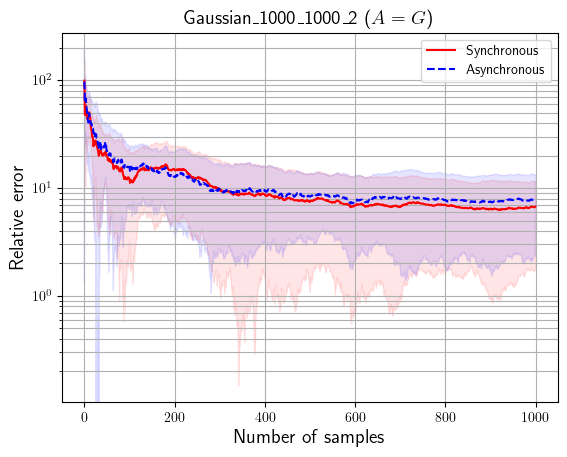

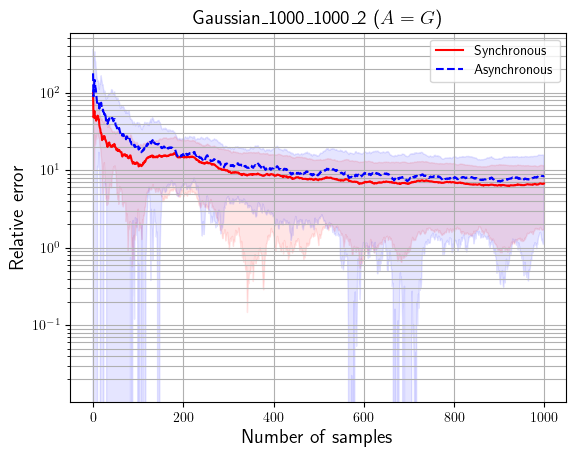

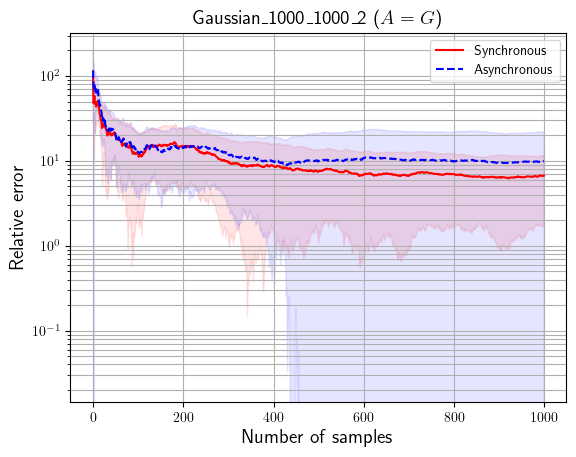

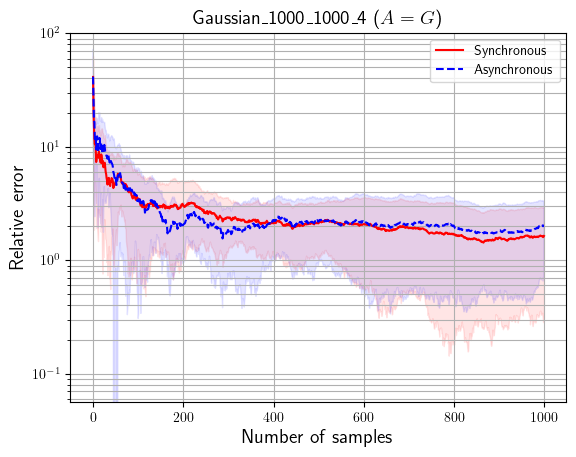

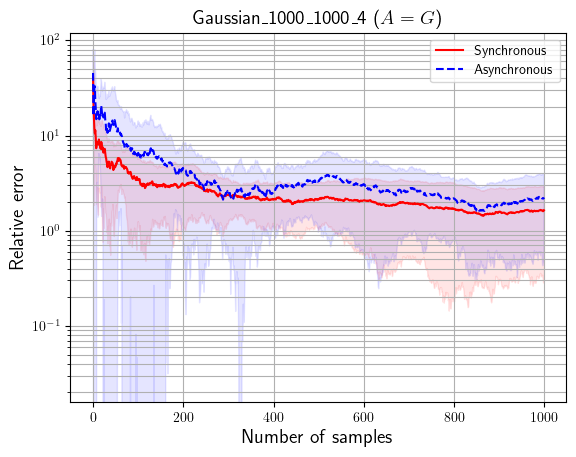

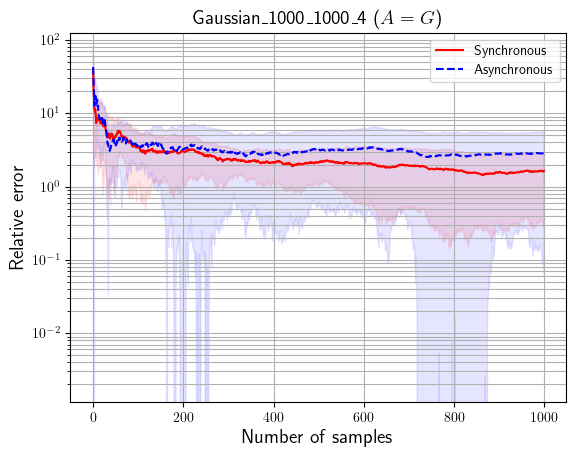

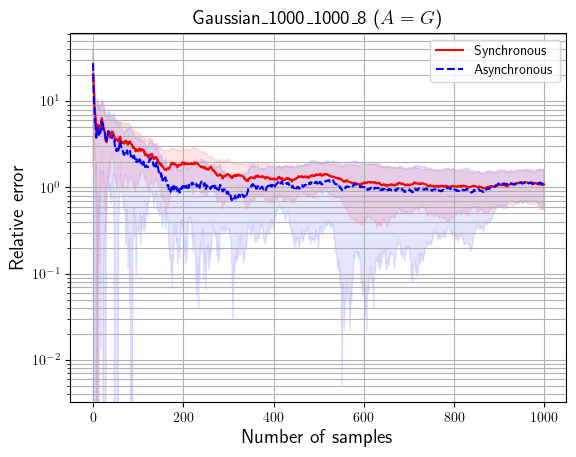

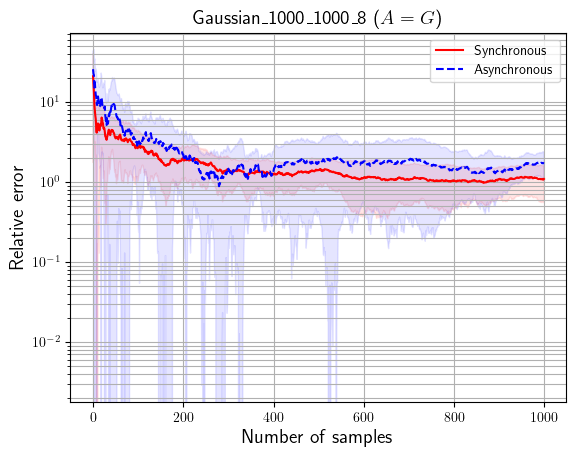

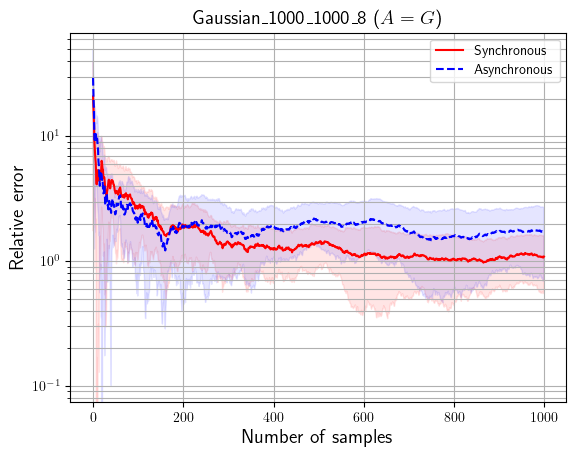

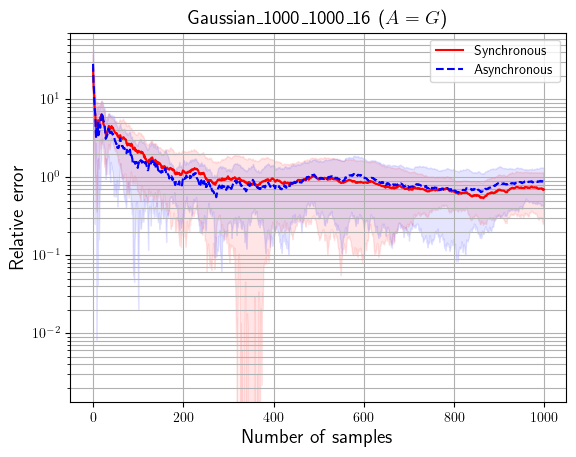

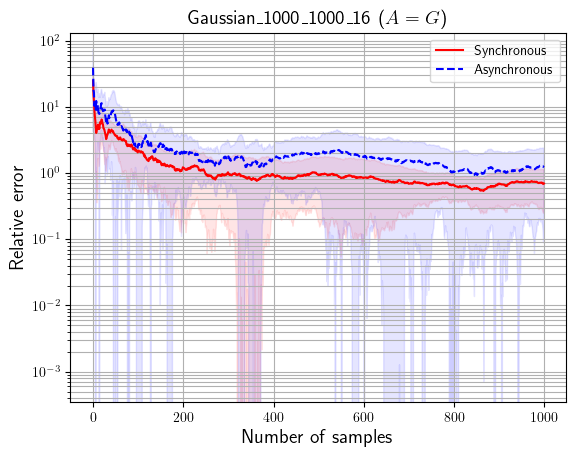

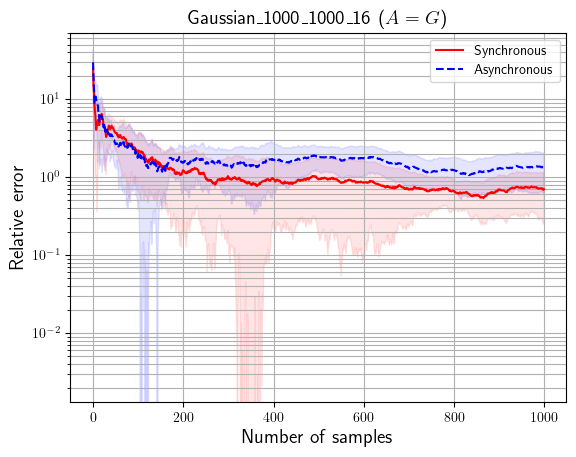

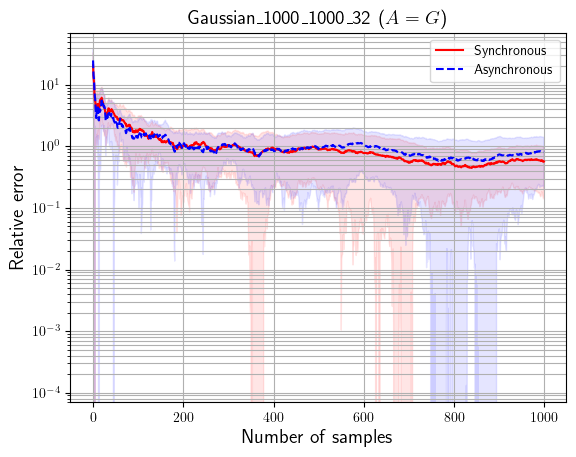

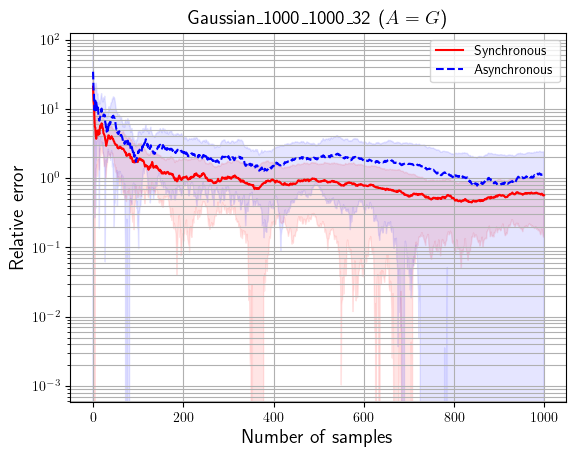

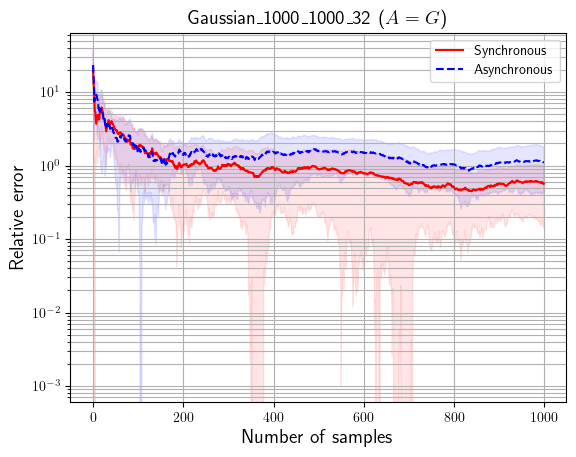

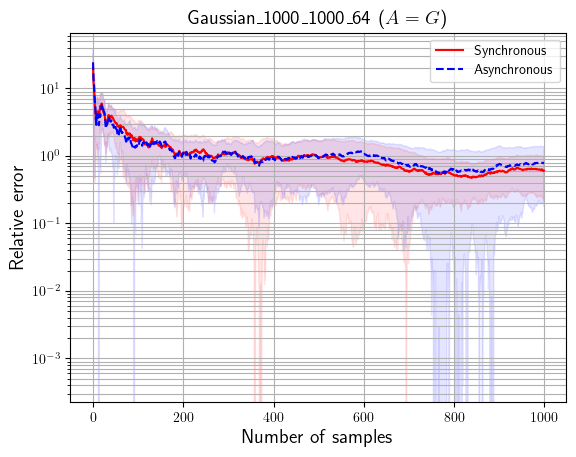

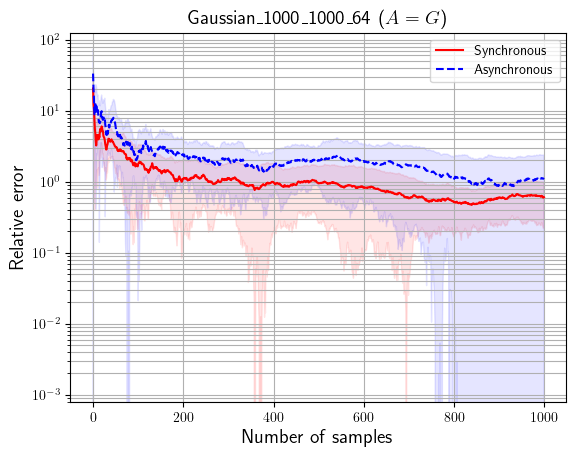

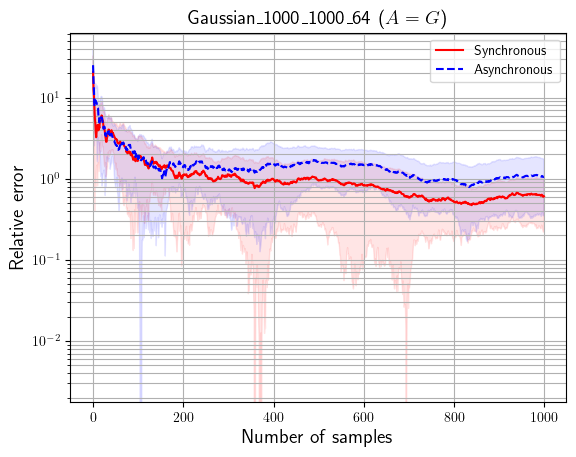

In [238]:
%%time
fig_dir = 'figures'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

result_dir = 'results'
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

matrix_key_list = list(matrix_label_dict.keys())


func_key_list   = ['G']
index_key_list  = ['fixed_T', 'uniform_T', 'fixed_p']
for matrix_key in matrix_key_list:
    for func_key in func_key_list:
        for index_key in index_key_list:
            
            result_fname = 'stochastic_rounding_relative_error-{}-{}-{}.pickle'.format(matrix_key, func_key, index_key)
            result_fpath = os.path.join(result_dir, result_fname)
            with open(result_fpath, 'rb') as f: 
                relative_error_list_dict_list = pickle.load(f)
            
            fig, ax    = make_plot_multiple(relative_error_list_dict_list)
            fig_fname = 'stochastic_rounding_relative_error-{}-{}-{}.pdf'.format(matrix_key, func_key, index_key)
            fig_fpath = os.path.join(fig_dir, fig_fname)
            fig.savefig(fig_fpath)

In [195]:
matrix_label = matrix_label_dict[matrix_key]
A            = A_dict[func_key][matrix_key]

0
CPU times: user 148 ms, sys: 2.45 ms, total: 151 ms
Wall time: 151 ms


In [196]:
matrix - quantized_matrix

array([[ 0.01271224, -0.00944445,  0.00312691, ..., -0.00545942,
        -0.00056563, -0.00675154],
       [-0.01057084, -0.01733855,  0.00014578, ...,  0.00130331,
        -0.01168874,  0.00599114],
       [ 0.00798248, -0.00035797, -0.01223223, ...,  0.0021317 ,
         0.0024359 ,  0.02060713],
       ...,
       [-0.0162713 , -0.01697521, -0.0017012 , ...,  0.00732938,
         0.01716293,  0.01153321],
       [-0.02665991, -0.00583863,  0.00691247, ..., -0.02351498,
        -0.00107677,  0.01608541],
       [ 0.014066  , -0.02243184, -0.02133387, ..., -0.00182406,
        -0.00032181,  0.01053861]])

In [185]:
quantized_matrix

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [178]:
def quantize(x, bin_index):
    bin_limits = bin_edges[bin_index]
    bin_min    = bin_limits[0]
    bin_max    = bin_limits[1]
    min_prob   = (bin_max - x) / (bin_max - bin_min)
    max_prob   = 1 - min_prob
    value      = np.random.choice(bin_limits, p=[min_prob, max_prob])
    return value

[0.  0.5]


0.5

In [140]:
bin_edges = [[bins[i], bins[i+1]] for i in range(len(bins) - 1)] 
bin_edges

[[0.0, 0.5], [0.5, 1.0]]

In [ ]:
sr(x) = q1 with probability q2−x and sr(x) = q2 otherwise3. q2 −q1

In [74]:
records = []
template_begin = r'\includegraphics[width=0.32\textwidth]{' 
template_end   = r'}'


fig_dir = 'figures'



matrix_key_list = ['Roget',
                    'bcsstm08', 
                    'plbuckle', 
                    'yeast',
                    'ca-GrQc',
                    'ca-HepTh', 
                    'ca-CondMat',
                    'thermomech_TC', 
                    'cnr-2000']

func_key_list   = ['G']
index_key_list  = ['fixed_T', 'uniform_T', 'fixed_p']
for matrix_key in matrix_key_list:
    record_list = []
    for func_key in func_key_list:
        for index_key in index_key_list:
            fig_fname = 'relative_error-{}-{}-{}.pdf'.format(matrix_key, func_key, index_key)
            fig_fpath = os.path.join(fig_dir, fig_fname)
            record = template_begin + fig_fpath + template_end
            record_list.append(record)
    records.append(record_list)

In [75]:
template_begin = r'\includegraphics[width=0.32\textwidth]{' 
template_end   = r'}'

fig_dir = 'figures'
matrix_key_list = ['email',
                   'wiki-Vote', 
                   'web-Stanford']

func_key_list   = ['GpI']
index_key_list  = ['fixed_T', 'uniform_T', 'fixed_p']
for matrix_key in matrix_key_list:
    record_list = []
    for func_key in func_key_list:
        for index_key in index_key_list:
            fig_fname = 'relative_error-{}-{}-{}.pdf'.format(matrix_key, func_key, index_key)
            fig_fpath = os.path.join(fig_dir, fig_fname)
            record = template_begin + fig_fpath + template_end
            record_list.append(record)
    records.append(record_list)

In [239]:
matrix_key_list

['Gaussian_1000_1000_2',
 'Gaussian_1000_1000_4',
 'Gaussian_1000_1000_8',
 'Gaussian_1000_1000_16',
 'Gaussian_1000_1000_32',
 'Gaussian_1000_1000_64']

In [247]:
records = []
template_begin = r'\includegraphics[width=0.32\textwidth]{' 
template_end   = r'}'

fig_dir = 'figures'
matrix_key_list = [
    'Gaussian_1000_1000_2',
    'Gaussian_1000_1000_4',
    'Gaussian_1000_1000_8',
    'Gaussian_1000_1000_16',
    'Gaussian_1000_1000_32',
    'Gaussian_1000_1000_64']


func_key_list   = ['G']
index_key_list  = ['fixed_T', 'uniform_T', 'fixed_p']
for matrix_key in matrix_key_list:
    record_list = []
    for func_key in func_key_list:
        for index_key in index_key_list:
            fig_fname = 'stochastic_rounding_relative_error-{}-{}-{}.pdf'.format(matrix_key, func_key, index_key)
            fig_fpath = os.path.join(fig_dir, fig_fname)
            record = template_begin + fig_fpath + template_end
            record_list.append(record)
    records.append(record_list)

[['\\includegraphics[width=0.32\\textwidth]{figures/stochastic_rounding_relative_error-Gaussian_1000_1000_2-G-fixed_T.pdf}',
  '\\includegraphics[width=0.32\\textwidth]{figures/stochastic_rounding_relative_error-Gaussian_1000_1000_2-G-uniform_T.pdf}',
  '\\includegraphics[width=0.32\\textwidth]{figures/stochastic_rounding_relative_error-Gaussian_1000_1000_2-G-fixed_p.pdf}'],
 ['\\includegraphics[width=0.32\\textwidth]{figures/stochastic_rounding_relative_error-Gaussian_1000_1000_4-G-fixed_T.pdf}',
  '\\includegraphics[width=0.32\\textwidth]{figures/stochastic_rounding_relative_error-Gaussian_1000_1000_4-G-uniform_T.pdf}',
  '\\includegraphics[width=0.32\\textwidth]{figures/stochastic_rounding_relative_error-Gaussian_1000_1000_4-G-fixed_p.pdf}'],
 ['\\includegraphics[width=0.32\\textwidth]{figures/stochastic_rounding_relative_error-Gaussian_1000_1000_8-G-fixed_T.pdf}',
  '\\includegraphics[width=0.32\\textwidth]{figures/stochastic_rounding_relative_error-Gaussian_1000_1000_8-G-uniform_T

In [249]:
import io
stream = io.StringIO()
for record_list in records:
    for record in record_list[:-1]:
        stream.write(record)
        stream.write('\n')
    stream.write(record_list[-1])
    stream.write('\\\\')
    stream.write('\n')

In [250]:
print(stream.getvalue())

\includegraphics[width=0.32\textwidth]{figures/stochastic_rounding_relative_error-Gaussian_1000_1000_2-G-fixed_T.pdf}
\includegraphics[width=0.32\textwidth]{figures/stochastic_rounding_relative_error-Gaussian_1000_1000_2-G-uniform_T.pdf}
\includegraphics[width=0.32\textwidth]{figures/stochastic_rounding_relative_error-Gaussian_1000_1000_2-G-fixed_p.pdf}\\
\includegraphics[width=0.32\textwidth]{figures/stochastic_rounding_relative_error-Gaussian_1000_1000_4-G-fixed_T.pdf}
\includegraphics[width=0.32\textwidth]{figures/stochastic_rounding_relative_error-Gaussian_1000_1000_4-G-uniform_T.pdf}
\includegraphics[width=0.32\textwidth]{figures/stochastic_rounding_relative_error-Gaussian_1000_1000_4-G-fixed_p.pdf}\\
\includegraphics[width=0.32\textwidth]{figures/stochastic_rounding_relative_error-Gaussian_1000_1000_8-G-fixed_T.pdf}
\includegraphics[width=0.32\textwidth]{figures/stochastic_rounding_relative_error-Gaussian_1000_1000_8-G-uniform_T.pdf}
\includegraphics[width=0.32\textwidth]{figures

In [61]:
for record in records:
    print(record)

['\\includegraphics[width=0.32\\textwidth]{figures/relative_error-email-GpI-fixed_T.pdf}', '\\includegraphics[width=0.32\\textwidth]{figures/relative_error-email-GpI-uniform_T.pdf}', '\\includegraphics[width=0.32\\textwidth]{figures/relative_error-email-GpI-fixed_p.pdf}']
['\\includegraphics[width=0.32\\textwidth]{figures/relative_error-wiki-Vote-GpI-fixed_T.pdf}', '\\includegraphics[width=0.32\\textwidth]{figures/relative_error-wiki-Vote-GpI-uniform_T.pdf}', '\\includegraphics[width=0.32\\textwidth]{figures/relative_error-wiki-Vote-GpI-fixed_p.pdf}']
['\\includegraphics[width=0.32\\textwidth]{figures/relative_error-web-Stanford-GpI-fixed_T.pdf}', '\\includegraphics[width=0.32\\textwidth]{figures/relative_error-web-Stanford-GpI-uniform_T.pdf}', '\\includegraphics[width=0.32\\textwidth]{figures/relative_error-web-Stanford-GpI-fixed_p.pdf}']


In [36]:
len(set(sparse_matrix.data))

1

In [34]:
type(sparse_matrix)

scipy.sparse._csc.csc_matrix

In [22]:
%%time
matrix_key = 'yeast'
# matrix_key = 'thermomech_TC'

func_key   = 'G'
index_key  = 'fixed_p'

sparse_matrix = A_dict[func_key][matrix_key]
N             = sparse_matrix.shape[0]

fixed_p     = 0.9
num_samples = 100
seed        = 0

fixed_T     = np.ceil(fixed_p * N)

seed_list = [i for i in range(10)]
relative_error_list_dict_list = []
for seed in seed_list:
    relative_error_list_dict = compute_relative_error_lists(matrix_key,
                                                        func_key,
                                                        index_key,
                                                        p          = fixed_p,
                                                        T          = fixed_T,
                                                        m          = num_samples,
                                                        seed       = seed)
    relative_error_list_dict_list.append(relative_error_list_dict)

CPU times: user 246 ms, sys: 6.94 ms, total: 253 ms
Wall time: 252 ms


In [33]:
matrix_labels

['ca-CondMat',
 'bcsstk20',
 'bcsstm08',
 'ca-HepTh',
 'ca-GrQc',
 'Roget',
 'minnesota',
 'wiki-Vote',
 'msc01440',
 'plbuckle',
 'yeast',
 'shallow_water1',
 'thermomech_TC',
 'web-Stanford',
 'cnr-2000',
 'email']

In [23]:
matrix_labels = list(matrix_label_dict.keys())

matrix_key_list = []
func_key_list   = ['G']
index_key_list  = ['fixed_T', 'uniform_T', 'fixed_p']

for matrix_key in matrix_labels:
    for func_key in func_key_list:
        sparse_matrix = A_dict[func_key][matrix_key]
        N             = sparse_matrix.shape[0]
        trace         = sparse_matrix.trace()
        if trace > 0:
            matrix_key_list.append(matrix_key)
print(matrix_key_list)

['ca-CondMat', 'bcsstk20', 'bcsstm08', 'ca-HepTh', 'ca-GrQc', 'Roget', 'plbuckle', 'yeast', 'shallow_water1', 'thermomech_TC', 'cnr-2000']


In [164]:
# matrix_list

In [175]:
data = sio.loadmat('data/bcsstk20.mat')

In [181]:
A = np.array(data['Problem'][0][0][1].todense())

In [184]:
sum([A[i, i] for i in range(A.shape[0])])

9.70146844277551e+16

In [160]:
scipy.sparse.

<1x1 sparse matrix of type '<class 'numpy.int64'>'
	with 1 stored elements in Compressed Sparse Column format>

In [152]:
type(sparse_matrix)

scipy.sparse._csc.csc_matrix

In [137]:
import mat73
data_dict = mat73.loadmat('data/cnr-2000.mat')

In [165]:
# data_dict

In [166]:
#import h5py
#with h5py.File('data/cnr-2000.mat', 'r') as f:
#    f.keys()

In [173]:
matrix_info = sorted(matrix_info, key = lambda x: x[1])

In [103]:
matrix_info

[['HB/bcsstk20', 485, 485, 3135],
 ['Pajek/Roget', 1022, 1022, 5075],
 ['HB/bcsstm08', 1074, 1074, 1074],
 ['Arenas/email', 1133, 1133, 10902],
 ['TKK/plbuckle', 1282, 1282, 30644],
 ['Boeing/msc01440', 1440, 1440, 44998],
 ['Pajek/yeast', 2361, 2361, 13828],
 ['Gleich/minnesota', 2642, 2642, 6606],
 ['SNAP/ca-GrQc', 5242, 5242, 28980],
 ['SNAP/wiki-Vote', 8297, 8297, 103689],
 ['SNAP/ca-HepTh', 9877, 9877, 51971],
 ['SNAP/ca-CondMat', 23133, 23133, 186936],
 ['MaxPlanck/shallow_water1', 81920, 81920, 327680],
 ['Botonakis/thermomech_TC', 102158, 102158, 711558],
 ['SNAP/web-Stanford', 281903, 281903, 2312497],
 ['LAW/cnr-2000', 325557, 325557, 3216152]]

In [116]:
'a_b'.replace('_', '\_')

'a\\_b'

In [46]:
from texttable import Texttable

table = Texttable()
table.set_cols_align(["l", "r", "c", "l"])
table.set_cols_valign(["t", "m", "b", "b"])

table_rows = [["\\textbf{Matrix name}", "$n$", "nnz", "$tr(\cdot)$"]]
for record in matrix_info:
    name  = '\\texttt{' + record[0].replace('_', '\_') + '}'
    n     = record[1]
    nnz   = record[3]
    trace = record[4] 
    table_rows.append([name, n, nnz, trace])

table.add_rows(table_rows)


print(latextable.draw_latex(table, caption="Matrices", label="table:matrices"))

\begin{table}
	\begin{center}
		\begin{tabular}{|l|r|c|l|}
			\hline
			\textbf{Matrix name} & $n$ & nnz & $tr(\cdot)$ \\
			\hline
			\texttt{Pajek/Roget} & 1022 & 5075 & 1 \\
			\hline
			\texttt{HB/bcsstm08} & 1074 & 1074 & 5502970.555 \\
			\hline
			\texttt{Arenas/email} & 1133 & 10902 & 0 \\
			\hline
			\texttt{TKK/plbuckle} & 1282 & 30644 & 3.208e+08 \\
			\hline
			\texttt{Pajek/yeast} & 2361 & 13828 & 536 \\
			\hline
			\texttt{SNAP/ca-GrQc} & 5242 & 28980 & 12 \\
			\hline
			\texttt{SNAP/wiki-Vote} & 8297 & 103689 & 0 \\
			\hline
			\texttt{SNAP/ca-HepTh} & 9877 & 51971 & 25 \\
			\hline
			\texttt{SNAP/ca-CondMat} & 23133 & 186936 & 58 \\
			\hline
			\texttt{Botonakis/thermomech\_TC} & 102158 & 711558 & 585.871 \\
			\hline
			\texttt{SNAP/web-Stanford} & 281903 & 2312497 & 0 \\
			\hline
			\texttt{LAW/cnr-2000} & 325557 & 3216152 & 87442 \\
			\hline
		\end{tabular}
	\end{center}
	\caption{Matrices}
	\label{table:matrices}
\end{table}


In [117]:
matrix_label_dict

{'ca-CondMat': 'SNAP/ca-CondMat',
 'bcsstm08': 'HB/bcsstm08',
 'ca-HepTh': 'SNAP/ca-HepTh',
 'ca-GrQc': 'SNAP/ca-GrQc',
 'Roget': 'Pajek/Roget',
 'wiki-Vote': 'SNAP/wiki-Vote',
 'plbuckle': 'TKK/plbuckle',
 'yeast': 'Pajek/yeast',
 'thermomech_TC': 'Botonakis/thermomech_TC',
 'web-Stanford': 'SNAP/web-Stanford',
 'cnr-2000': 'LAW/cnr-2000',
 'email': 'Arenas/email'}

In [19]:
results = ssgetpy.search('Arenas/email')
results[0].download(format='MAT', destpath='data/')

email:   0%|          | 0/20606 [00:00<?, ?B/s]

('data/email.mat', 'data/email.mat')

'email'

In [89]:
data = sparse_matrix.data

In [95]:
data.shape
matrix_min = sparse_matrix.min()
matrix_max = sparse_matrix.max()

    

In [97]:
matrix_min, matrix_max

(0.0, 1.0)

In [107]:
num_quantization_levels = 3

bins = np.linspace(matrix_min, matrix_max, num_quantization_levels)
bins

array([0. , 0.5, 1. ])

In [113]:
np.digitize([0.0, 0.6], bins)

array([1, 2])

In [115]:
matr

array([0. , 0.5, 1. ])

In [116]:
A_dict['G']

{'G': {'ca-CondMat': <23133x23133 sparse matrix of type '<class 'numpy.float64'>'
  	with 186936 stored elements in Compressed Sparse Column format>,
  'bcsstm08': <1074x1074 sparse matrix of type '<class 'numpy.float64'>'
  	with 1074 stored elements in Compressed Sparse Column format>,
  'ca-HepTh': <9877x9877 sparse matrix of type '<class 'numpy.float64'>'
  	with 51971 stored elements in Compressed Sparse Column format>,
  'ca-GrQc': <5242x5242 sparse matrix of type '<class 'numpy.float64'>'
  	with 28980 stored elements in Compressed Sparse Column format>,
  'Roget': <1022x1022 sparse matrix of type '<class 'numpy.float64'>'
  	with 5075 stored elements in Compressed Sparse Column format>,
  'wiki-Vote': <8297x8297 sparse matrix of type '<class 'numpy.float64'>'
  	with 103689 stored elements in Compressed Sparse Column format>,
  'plbuckle': <1282x1282 sparse matrix of type '<class 'numpy.float64'>'
  	with 30644 stored elements in Compressed Sparse Column format>,
  'yeast': <23

In [2]:
seed    = 0
N       = 1000000

degree  = 5
density = None

if degree is not None:
    density = degree / N

np.random.seed(seed)

nnz = int(N * N * density)

row = np.random.choice(N, nnz, replace=True)
col = np.random.choice(N, nnz, replace=True)
val = np.random.randn(nnz)

G = sp.csr_array(sp.coo_matrix((val, (row, col)), shape=(N, N)))

# G = sp.random(N, N, density=density)

# G = G + G.T + sp.identity(N)

G = G + G.T + sp.diags(np.random.randn(N))

A = G

matrix_fpath_dict = {'random' : None}
matrix_label_dict = {'random' : 'Random matrix (N={}, density={})'.format(N, density)}
func_label_dict   = {'G'      : '$A = G$'}

G_dict = {}
G_dict['random'] = A
A_dict = {'G' : G_dict}


print({'N'     : N,
       'trace' : A.trace(), 
       'nnz'   : A.nnz})

{'N': 1000000, 'trace': -1010.5584076406051, 'nnz': 10999942}


In [ ]:
matrix_fpath_dict = {'email'    : 'email.mat',
                     'msc01440' : 'msc01440.mat',
                     'plbuckle' : 'plbuckle.mat',
                     'yeast'    : 'yeast.mat'}

data_dict            = {}
sparse_matrix_dict   = {} 

G_dict               = {}
#GTG_dict             = {}
#expG_dict            = {}
#G3_dict              = {}


matrix_label_dict = {'email'    : 'Arenas/email',
                     'msc01440' : 'Boeing/msc01440',
                     'plbuckle' : 'TKK/plbuckle',
                     'yeast'    : 'Pajel/yeast'}

func_label_dict = {'G'    : '$A = G$',
                   'GTG'  : '$A = G^T G$',
                   'expG' : '$A = e^{G}$',
                   'G3'   : '$A = G^3$'}

A_dict = {'G'    : G_dict,
          'GTG'  : GTG_dict,
          'expG' : expG_dict,
          'G3'   : G3_dict}      

In [203]:
def randemacher_vector(size):
    return np.random.choice([-1.0, 1.0], size=size, replace=True, p=[0.5, 0.5])

In [204]:
def randemacher_vector_samples(size, num_samples, seed=0):
    np.random.seed(seed)
    return [randemacher_vector(size) for _ in range(num_samples)]

In [205]:
# Could be  made generic: passing two distributions could do the trick. e.g. from `scipy.stats`
# dist1 to choose T; dist2 to get indices of active rows 
def general_index_samples(size, num_samples, seed=0):
    pass
  

In [206]:
# corollary 1
def fixed_T_index_samples(size, num_samples, T, seed=0):
    np.random.seed(seed)
    num_active = T
    index_samples = []
    for _ in range(num_samples):
        sample = np.sort(np.random.choice(size, size=num_active, replace=False, p=None))
        index_samples.append(sample)
    return index_samples

# corollary 2
def uniform_T_index_samples(size, num_samples, seed=0):
    np.random.seed(seed)
    num_active = np.random.randint(0, size, 1)
    index_samples = []
    for _ in range(num_samples):
        sample = np.sort(np.random.choice(size, size=num_active, replace=False, p=None))
        index_samples.append(sample)
    return index_samples
        

# corollary 3
def fixed_p_index_samples(size, num_samples, p, seed=0):
    np.random.seed(seed)
    index_samples = []
    num_choices   = size
    for _ in range(num_samples):
        sample = np.where(np.random.random(num_choices) <= p)[0]
        index_samples.append(sample)
    return index_samples 

In [207]:
def compute_relative_error_lists(matrix_key,
                                func_key,
                                index_key,
                                p          = 0.6,
                                T          = 800,
                                m          = 500,
                                seed       = 0):
    
    matrix_label = matrix_label_dict[matrix_key]
    A            = A_dict[func_key][matrix_key]
    N            = A.shape[0] 
    trace        = A.trace()

    x_list = randemacher_vector_samples(N, m, seed=seed)

    if index_key == 'fixed_T':
        index_samples = fixed_T_index_samples(N, m, T, seed=seed)
    elif index_key == 'uniform_T':
        index_samples = uniform_T_index_samples(N, m, seed=seed)
    elif index_key == 'fixed_p':
        index_samples = fixed_p_index_samples(N, m, p, seed=seed)

    sync_quadratic_list  = []
    async_quadratic_list = []

    mu_T = 0

    for i in range(m):
        k = i + 1
        x = x_list[i]
        idx = index_samples[i]
    
        sync_quadratic = x @ (A @ x)
        sync_quadratic_list.append(sync_quadratic)
    
        async_A =  A[idx]
        matvec = async_A @ x
        y = np.zeros(N)
        y[idx] = matvec
        async_quadratic = x @ y
        async_quadratic_list.append(async_quadratic)
        mu_T = mu_T + len(idx)

    mu_T = mu_T / m
    
    sync_trace_list  = []
    async_trace_list = []

    sync_sum  = 0.
    async_sum = 0.
    for i in range(m):
        k = i + 1
    
        sync_sum   += sync_quadratic_list[i]
        sync_trace = 1. / k * sync_sum
        sync_trace_list.append(sync_trace)
    
        async_sum   += async_quadratic_list[i]
        async_trace = N / mu_T * 1. / k * async_sum
        async_trace_list.append(async_trace)

    sync_relative_error_list  = []
    async_relative_error_list = []

    for i in range(m):
        sync_relative_error = abs(sync_trace_list[i] - trace) / abs(trace)
        sync_relative_error_list.append(sync_relative_error)
    
        async_relative_error = abs(async_trace_list[i] - trace) / abs(trace)
        async_relative_error_list.append(async_relative_error)
    
    relative_error_list_dict = {'sync'  : sync_relative_error_list,
                                'async' : async_relative_error_list}
    
    return relative_error_list_dict

In [9]:
def make_plot(relative_error_list_dict):
    
    sync_relative_error_list  = relative_error_list_dict['sync']
    async_relative_error_list = relative_error_list_dict['async']
    
    
    fig, ax = plt.subplots(1)
    ax.plot(async_relative_error_list, '--', color='blue', label='Asynchronous')
    ax.plot(sync_relative_error_list,  color='red',   label='Synchronous')

    ax.set_yscale('log')
    ax.grid(which='both')
    ax.legend()

    ax.set_ylim(top=1.)

    # plt.title('Randomized trace estimation',  fontsize=14);
    ax.set_title('{} ({})'.format(matrix_label_dict[matrix_key], 
                           func_label_dict[func_key]),  fontsize=14);
    ax.set_xlabel('Number of samples', fontsize=14);
    ax.set_ylabel('Relative error', fontsize=14);
    return fig, ax
    

CPU times: user 14min 53s, sys: 3min 38s, total: 18min 31s
Wall time: 2min 59s


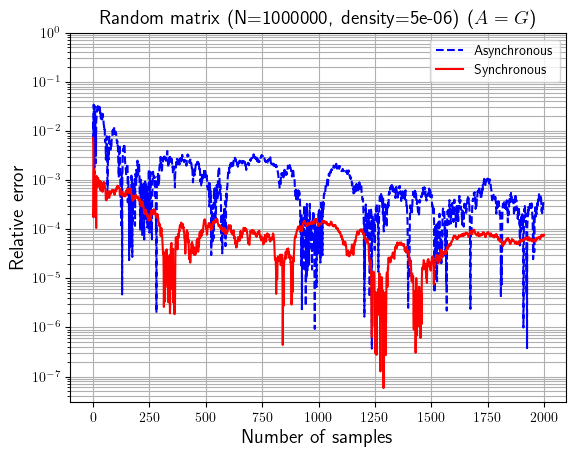

In [84]:
%%time
fig_dir = 'figs'

if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

matrix_key_list = ['random']
func_key_list   = ['G']
# index_key_list  = ['fixed_T', 'uniform_T', 'fixed_p']
index_key_list  = ['fixed_T']


for matrix_key in matrix_key_list:
    for func_key in func_key_list:
        for index_key in index_key_list:
            try:
                relative_error_list_dict = compute_relative_error_lists(matrix_key,
                                                                    func_key,
                                                                    index_key,
                                                                    p          = 0.6,
                                                                    T          = 1000,
                                                                    m          = 2000,
                                                                    seed       = 0)
                fig, ax    = make_plot(relative_error_list_dict)
                fig_fname = 'relative_error-{}-{}-{}.pdf'.format(matrix_key, func_key, index_key)
                fig_fpath = os.path.join(fig_dir, fig_fname)
                # fig.show()
                fig.savefig(fig_fpath)
            except:
                print(matrix_key, fun_key, index_key)
            

CPU times: user 14min, sys: 3min 17s, total: 17min 17s
Wall time: 3min 12s


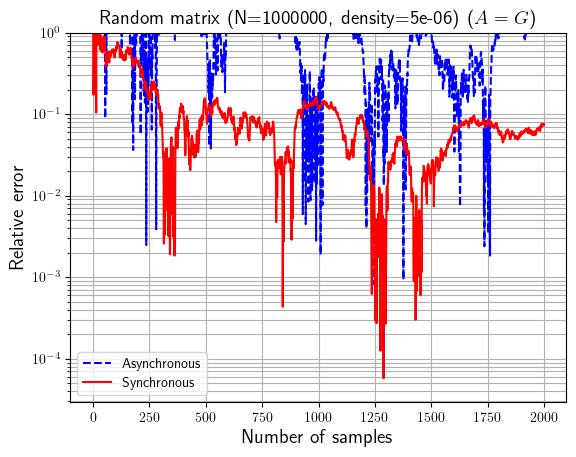

In [17]:
%%time
fig_dir = 'figs'

if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

matrix_key_list = ['random']
func_key_list   = ['G']
# index_key_list  = ['fixed_T', 'uniform_T', 'fixed_p']
index_key_list  = ['fixed_T']


for matrix_key in matrix_key_list:
    for func_key in func_key_list:
        for index_key in index_key_list:
            try:
                relative_error_list_dict = compute_relative_error_lists(matrix_key,
                                                                    func_key,
                                                                    index_key,
                                                                    p          = 0.6,
                                                                    T          = 1000,
                                                                    m          = 2000,
                                                                    seed       = 0)
                fig, ax    = make_plot(relative_error_list_dict)
                fig_fname = 'relative_error-{}-{}-{}.pdf'.format(matrix_key, func_key, index_key)
                fig_fpath = os.path.join(fig_dir, fig_fname)
                # fig.show()
                fig.savefig(fig_fpath)
            except:
                print(matrix_key, fun_key, index_key)
            

CPU times: user 27min 21s, sys: 7min 10s, total: 34min 31s
Wall time: 5min 49s


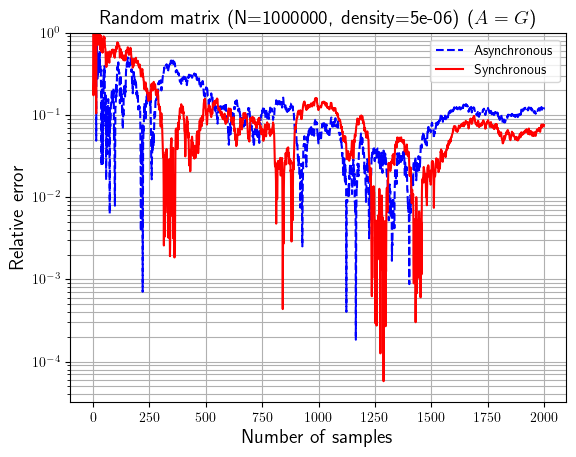

In [10]:
%%time
fig_dir = 'figs'

if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

matrix_key_list = ['random']
func_key_list   = ['G']
# index_key_list  = ['fixed_T', 'uniform_T', 'fixed_p']
index_key_list  = ['fixed_T']


for matrix_key in matrix_key_list:
    for func_key in func_key_list:
        for index_key in index_key_list:
            try:
                relative_error_list_dict = compute_relative_error_lists(matrix_key,
                                                                    func_key,
                                                                    index_key,
                                                                    p          = 0.6,
                                                                    T          = 600000,
                                                                    m          = 2000,
                                                                    seed       = 0)
                fig, ax    = make_plot(relative_error_list_dict)
                fig_fname = 'relative_error-{}-{}-{}.pdf'.format(matrix_key, func_key, index_key)
                fig_fpath = os.path.join(fig_dir, fig_fname)
                # fig.show()
                fig.savefig(fig_fpath)
            except:
                print(matrix_key, fun_key, index_key)
            

In [21]:
A = sparse_matrix

In [23]:
A.min()

0.0

In [24]:
A.max()

1.0

In [27]:
print(func_key)
func_key   = 'G'

A = A_dict[func_key][matrix_key]

A.min(), A.max()

G


(0.0, 1.0)

In [12]:
matrix_key = 'email'
func_key   = 'G'

A = A_dict[func_key][matrix_key]
np.trace(A)

0.0

In [17]:
matrix_key = 'msc01440'
func_key   = 'G'

A = A_dict[func_key][matrix_key]
np.trace(A)

0.0

In [13]:
matrix_key = 'plbuckle'
func_key   = 'expG'

A = A_dict[func_key][matrix_key]
np.trace(A)

nan